# Name: Nalet

- Please answer the question in the same order as in the assignment and use the same question numbers;
- Don't answer the questions in the code comments. Use the text cells in your notebook;
- Remove clutter such as unused code lines instead of turning them into comments;
- Make sure the right execution order of the notebook cells is from top to bottom. A TA should be able to reproduce your results by simply clicking "Run All" without having to guess which cells should be executed first.

# Assignment 1 ATML 2020
Download the dataset files from ILIAS and put them in the same folder as this notebook.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
!pip install -U tqdm
import torch
from tqdm.notebook import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

images = np.load('data/imgs_train.npy')
labels = np.load('data/labels_train.npy')

test_images = np.load('data/imgs_test.npy')
test_labels = np.load('data/labels_test.npy')

print(images.shape)
print(labels.shape)
print(test_images.shape)
print(test_labels.shape)

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.43.0)
(5000, 64, 64, 3)
(5000,)
(8000, 64, 64, 3)
(8000,)


## Task 1. Prepare data for training and model selection

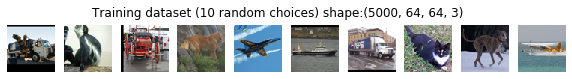

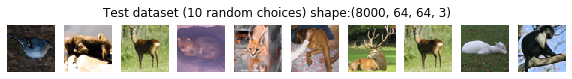

In [0]:
%matplotlib inline

img_choices = np.random.choice(5000, 10)
fig, axs = plt.subplots(1, 10, figsize=(10, 3))
for ax, selected_img in zip(axs, img_choices):
    ax.imshow(images[selected_img])
    ax.axis('off')

fig.suptitle('Training dataset (10 random choices) shape:' + str(images.shape))
fig.subplots_adjust(top=1.45)    
plt.show()

img_choices = np.random.choice(5000, 10)
fig, axs = plt.subplots(1, 10, figsize=(10, 3))
for ax, selected_img in zip(axs, img_choices):
    ax.imshow(test_images[selected_img])
    ax.axis('off')

fig.suptitle('Test dataset (10 random choices) shape:' + str(test_images.shape))
fig.subplots_adjust(top=1.45)    
plt.show()

In [0]:
import torch
from torch.utils.data import Dataset
class NumpyDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        # Anything could go here, e.g. image loading from file or a different structure
        # must return samples and targets/labels (x and y in our case)
        datapoint = self.data[index]
        target = self.target[index]
        return torch.tensor([datapoint]), torch.tensor([target])
    
    def __len__(self):
        return len(self.data)
        # must return number of examples

train_dataset = NumpyDataset(images, labels)

In [0]:
from torch.utils.data import DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) #num_workers = n - how many threads in background for efficient loading

In [0]:
# Same for validation dataset
val_dataset = NumpyDataset(test_images, test_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [0]:
import torch.nn as nn
class LinearModel(nn.Module):
    
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(input_dim, 2, bias=True) # outputs 2 values - score for cat and score for dog
        
    def forward(self, input):
        out = input.view(input.size(0), -1) # convert batch_size x 3 x imH x imW to batch_size x (3*imH*imW)
        out = self.fc(out) # Applies out = input * A + b. A, b are parameters of nn.Linear that we want to learn
        return out
    
class MLPModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [0]:
model = LinearModel(64*64*3)
model = model.to(device)

# Initialize loss function, optimizer and parameters
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0
    # Iterate mini batches over training dataset
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # Run predictions
        output = model(images)
        # Set gradients to zero
        optimizer.zero_grad()
        # Compute loss
        loss = loss_fn(output, labels)
        # Backpropagate (compute gradients)
        loss.backward()
        # Make an optimization step (update parameters)
        optimizer.step()
        # Log metrics
        losses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(losses).mean()
    return mean_loss, accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Run predictions
            output = model(images)
            # Compute loss
            loss = loss_fn(output, labels)
            # Save metrics
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            losses.append(loss.item())
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    # Return mean loss and accuracy
    return mean_loss, accuracy

def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies

## Task 2. Train a linear classification model

In [0]:
model = LinearModel(64*64*3)
model = model.to(device)

# Initialize loss function, optimizer and parameters
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 25

train_losses, val_losses, train_acc, val_acc = train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_fn)

RuntimeError: ignored

In [0]:
# np.savez('losses_linear_lr1e-3.npz', train_losses=train_losses, val_losses=val_losses, train_accuracies=train_accuracies, val_accuracies=val_accuracies)
# linear_model_data = np.load('losses_linear_lr1e-3.npz')
# train_losses, val_losses, train_accuracies, val_accuracies = linear_model_data['train_losses'], linear_model_data['val_losses'], linear_model_data['train_accuracies'], linear_model_data['val_accuracies']

def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(np.arange(n_epochs), train_losses)
    plt.plot(np.arange(n_epochs), val_losses)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('Train/val loss');

    plt.figure()
    plt.plot(np.arange(n_epochs), train_accuracies)
    plt.plot(np.arange(n_epochs), val_accuracies)
    plt.legend(['train_acc', 'val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Train/val accuracy');

plot(n_epochs, train_losses, val_losses, train_acc, val_acc)

#### Report below:
**REPORT** *plots, validation losses and accuracies for different learning rates, learning rate for the selected best performing model*

## Task 3. Evaluate on the test set

In [0]:
# write your code

#### Report below:
**REPORT**:
*Compare validation and test acccuracy. Comment on differences.  
How are test images different from train images?  
Visualize weights of your best linear model. What did the model learn? How does it distinguish images? Why does it fail on test images?*

## Task 4. Fix the observed problem

In [0]:
# write your code

#### Report below
*Traning and validation loss and accuracy for different learning rates  
Learning rate of the best model  
Test loss and accuracy for the best model  
Compare training, val and test loss and accuracy with the previous model  
Visualize weights of the new model, comment on the differences*
